# Banana Quality
### Classify for Explainability & Insight

### Import Libraries

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install scikit-learn==1.6.1
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, log_loss

# !pip install lightgbm==4.6.0
import lightgbm as lgb

# !pip install optuna==4.3.0
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate

# !pip install shap==0.47.2
import shap

### Variables

In [146]:
good_color = 'gold'
bad_color = 'yellowgreen'

### Load Data
- https://www.kaggle.com/datasets/l3llff/banana?resource=download

In [147]:
df = pd.read_csv('Banana_Quality.csv')
df

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,-1.924968,0.468078,3.077832,-1.472177,0.294799,2.435570,0.271290,Good
1,-2.409751,0.486870,0.346921,-2.495099,-0.892213,2.067549,0.307325,Good
2,-0.357607,1.483176,1.568452,-2.645145,-0.647267,3.090643,1.427322,Good
3,-0.868524,1.566201,1.889605,-1.273761,-1.006278,1.873001,0.477862,Good
4,0.651825,1.319199,-0.022459,-1.209709,-1.430692,1.078345,2.812442,Good
...,...,...,...,...,...,...,...,...
7995,-6.414403,0.723565,1.134953,2.952763,0.297928,-0.156946,2.398091,Bad
7996,0.851143,-2.217875,-2.812175,0.489249,-1.323410,-2.316883,2.113136,Bad
7997,1.422722,-1.907665,-2.532364,0.964976,-0.562375,-1.834765,0.697361,Bad
7998,-2.131904,-2.742600,-1.008029,2.126946,-0.802632,-3.580266,0.423569,Bad


### Feature Engineering

In [148]:
# Binary encoding
df['Quality'] = np.where(df['Quality'] == 'Good', 1, 0)

In [149]:
# Create an interaction term
df['Acidity_x_Softness'] = df['Acidity'] * df['Softness']

### EDA

In [150]:
df['Quality'].value_counts()

Quality
1    4006
0    3994
Name: count, dtype: int64

In [151]:
df.isna().sum()

Size                  0
Weight                0
Sweetness             0
Softness              0
HarvestTime           0
Ripeness              0
Acidity               0
Quality               0
Acidity_x_Softness    0
dtype: int64

In [152]:
features = [c for c in df.columns.tolist() if c != 'Quality']
target = 'Quality'

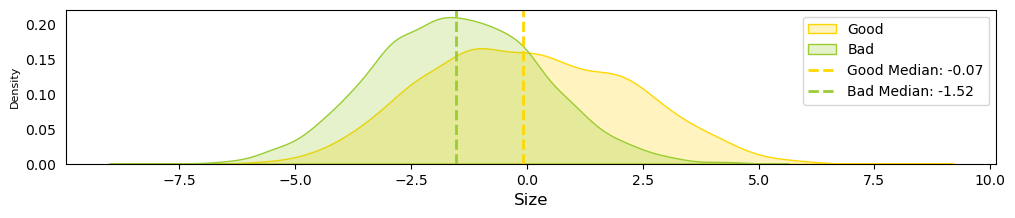

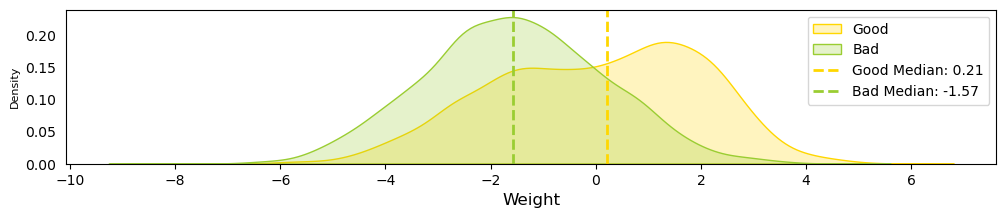

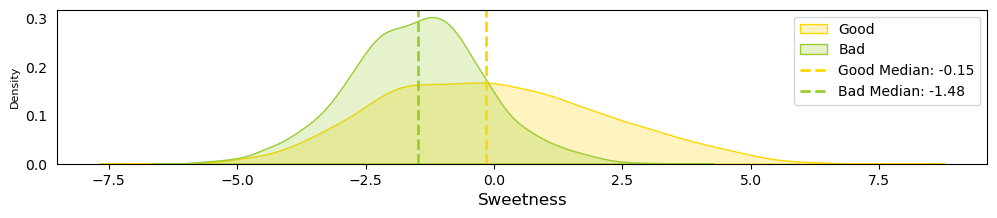

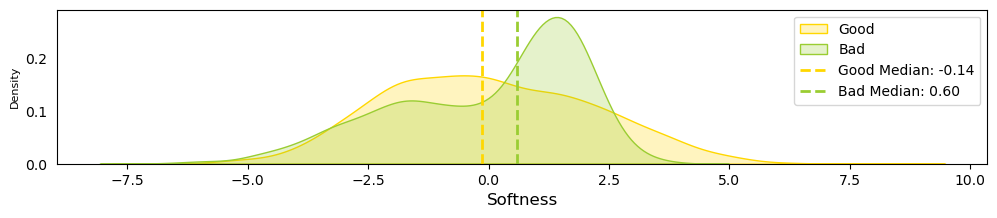

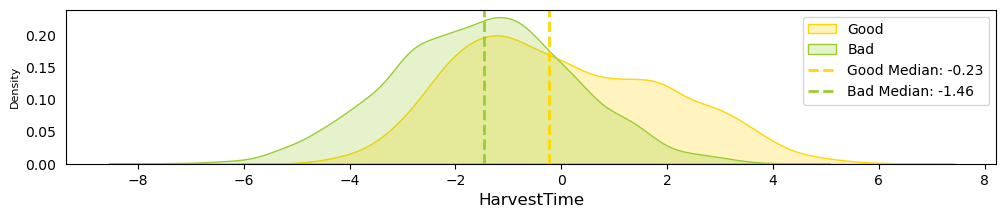

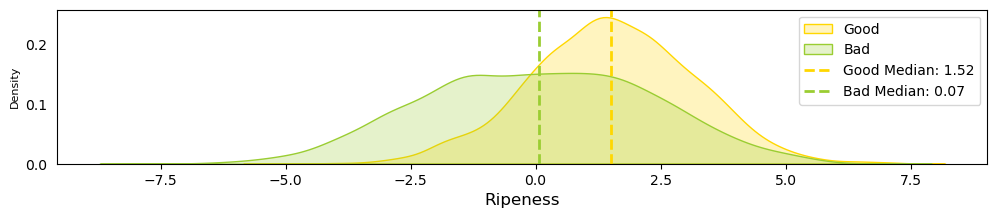

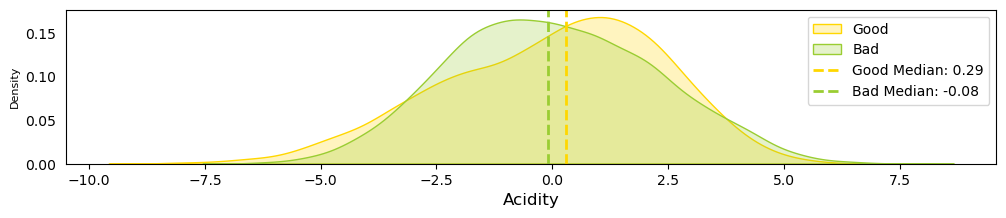

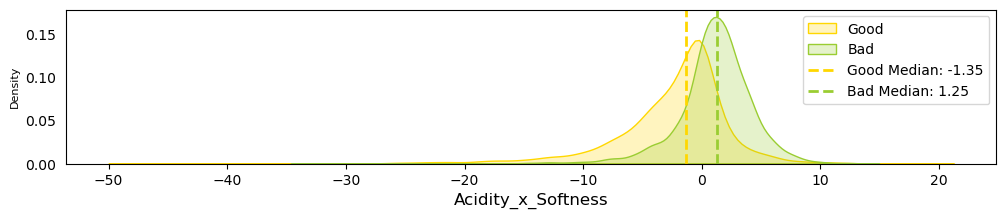

In [153]:
for col in features:
    plt.figure(figsize=(12, 2))
    sns.kdeplot(df[df['Quality']==1][col], label='Good', fill = True, color = good_color)
    sns.kdeplot(df[df['Quality']==0][col], label='Bad', fill = True, color = bad_color )
    median_good= df[df['Quality']==1][col].median()
    median_bad = df[df['Quality']==0][col].median()
    plt.axvline(median_good, color=good_color, linestyle='dashed', linewidth=2, label=f'Good Median: {median_good:.2f}')
    plt.axvline(median_bad, color=bad_color, linestyle='dashed', linewidth=2, label=f'Bad Median: {median_bad:.2f}')
    plt.xlabel(col, fontsize=12);
    plt.ylabel('Density', fontsize=8)
    plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)
    plt.legend()
    plt.show()

### Train Test Split

In [154]:
X = df[features]
y = df[target]

In [155]:
# Split into train and val/test by percentage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the temp set into validation and test sets 50% each
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [156]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (6400, 8)
Shape of X_val: (800, 8)
Shape of X_test: (800, 8)


In [157]:
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of y_train: (6400,)
Shape of y_val: (800,)
Shape of y_test: (800,)


### Manual LightGBM Model - Evaluation

In [158]:
# Parameters for the current model
current_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',  
    'boosting_type': 'gbdt',
    'n_estimators':1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42,
    'scale_pos_weight': 2.0,
    'n_jobs': -1,
    'verbose': -1,
}

In [159]:
# Initialize the LightGBMClassifier
lgbm_model = lgb.LGBMClassifier(**current_params)

# Train the LightGBM model with early stopping
eval_set = [(X_train, y_train), (X_val, y_val)]
evals_result = {}

lgbm_model.fit(X_train, y_train,
                eval_set=eval_set,
                eval_metric=['auc', 'binary_logloss'],
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=1),
                            lgb.record_evaluation(evals_result)])

# Make predictions on the test set
y_pred = lgbm_model.predict(X_test)
y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	training's auc: 0.999925	training's binary_logloss: 0.0268851	valid_1's auc: 0.992046	valid_1's binary_logloss: 0.101327


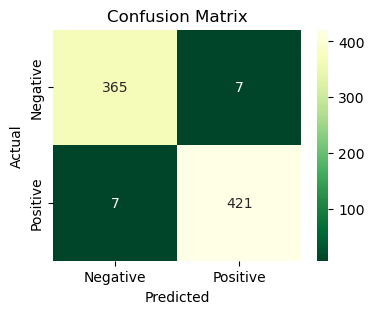

In [160]:
# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGn_r',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [161]:
# Print classification report (F1-score, Recall, Precision)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       372
           1       0.98      0.98      0.98       428

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



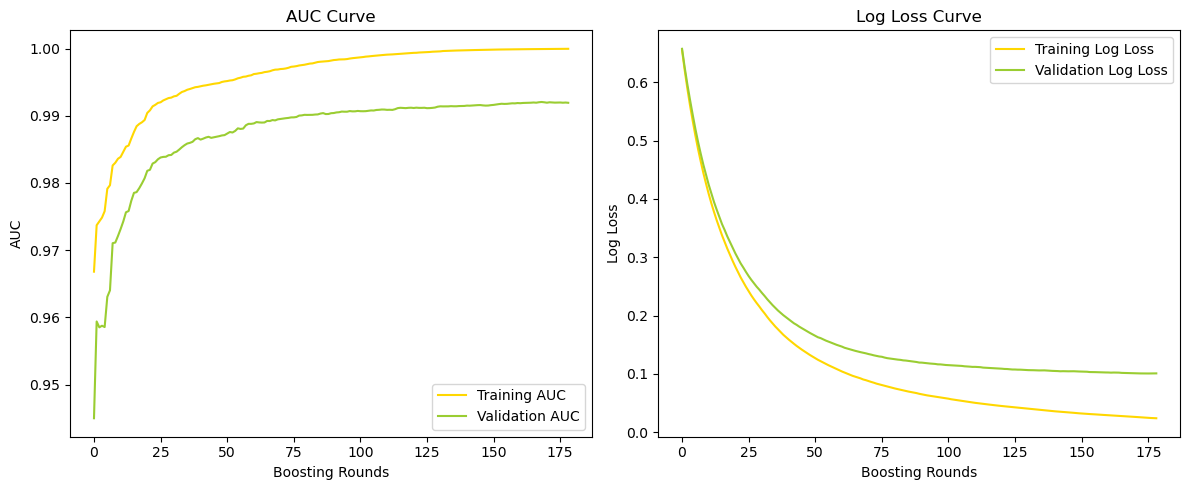

In [162]:
# Visualize the loss curves
epochs = len(evals_result['training']['auc']) 
plt.figure(figsize=(12, 5))

# Plot AUC
plt.subplot(1, 2, 1)
plt.plot(evals_result['training']['auc'], label='Training AUC', color = good_color)
plt.plot(evals_result['valid_1']['auc'], label='Validation AUC', color = bad_color)
plt.title('AUC Curve')
plt.xlabel('Boosting Rounds')
plt.ylabel('AUC')
plt.legend()

# Plot Log Loss
plt.subplot(1, 2, 2)
plt.plot(evals_result['training']['binary_logloss'], label='Training Log Loss', color = good_color)
plt.plot(evals_result['valid_1']['binary_logloss'], label='Validation Log Loss', color = bad_color)
plt.title('Log Loss Curve')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Optuna LightGBM Model

In [163]:
def objective(trial):
    """Objective function for Optuna to minimize."""
    params = {
        'objective': current_params['objective'],
        'metric': current_params['metric'],
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': current_params['random_state'],
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),
        'n_jobs': current_params['n_jobs']
    }

    model = lgb.LGBMClassifier(**params, verbose=-1)
    model.fit(X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='binary_logloss',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)],
                )

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    logloss = log_loss(y_val, y_pred_proba)

    return logloss

In [164]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Enqueue the current parameters as a starting point
study.enqueue_trial(current_params)

# Run the optimization
study.optimize(objective, n_trials=500,  show_progress_bar=False)  

[I 2025-06-02 09:08:27,207] A new study created in memory with name: no-name-a2695472-143d-4dfe-a0ae-a7900365b73f
[I 2025-06-02 09:08:27,441] Trial 0 finished with value: 0.10077578396638234 and parameters: {'n_estimators': 1000, 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 23, 'subsample': 0.964423653373087, 'colsample_bytree': 0.9971269528111758, 'scale_pos_weight': 2.0}. Best is trial 0 with value: 0.10077578396638234.
/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/lightgbm/callback.py:333: UserWarning:

Early stopping is not available in dart mode

[I 2025-06-02 09:08:35,627] Trial 1 finished with value: 0.12889488557509574 and parameters: {'n_estimators': 1710, 'boosting_type': 'dart', 'learning_rate': 0.2167647194971576, 'num_leaves': 91, 'max_depth': 3, 'min_child_samples': 27, 'subsample': 0.9794247106204511, 'colsample_bytree': 0.6133341887831756, 'scale_pos_weight': 4.1380295948365555}. Best is tr

In [165]:
# Visualize optimization history
fig_history = plot_optimization_history(study)
fig_history.show()

In [166]:
# Visualize parameter importances
fig_importance = plot_param_importances(study)
fig_importance.show()

In [167]:
# Visualize parallel coordinate plot (for multi-dimensional parameter relationships)
fig_parallel = plot_parallel_coordinate(study)
fig_parallel.show()


In [168]:
# Get the best parameters found by Optuna
best_params = study.best_params
print(f"Best parameters found by Optuna:\n")
for key, value in best_params.items():
    print(f'{key}: {value}')


Best parameters found by Optuna:

n_estimators: 880
boosting_type: goss
learning_rate: 0.19334240104442546
num_leaves: 20
max_depth: 0
min_child_samples: 24
subsample: 0.732826877380072
colsample_bytree: 0.9767938032615985
scale_pos_weight: 1.1251865232648344


### Final LightGBM Model

In [169]:
# Join back the Train and Val sets
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

In [170]:
# Manually make any changes as needed
# best_params['scale_pos_weight'] = 3.0

In [171]:
# Train the final model with the best parameters
final_model = lgb.LGBMClassifier(**best_params,
                                    objective=current_params['objective'],
                                    metric=['auc', 'binary_logloss'],
                                    random_state=current_params['random_state'],
                                    n_jobs=current_params['n_jobs']
                                    )

final_model.fit(X_train, y_train,
                eval_metric=['auc', 'binary_logloss'],
                )

# Make predictions on the test set
y_pred_final = final_model.predict(X_test)
y_pred_proba_final = final_model.predict_proba(X_test)[:, 1]

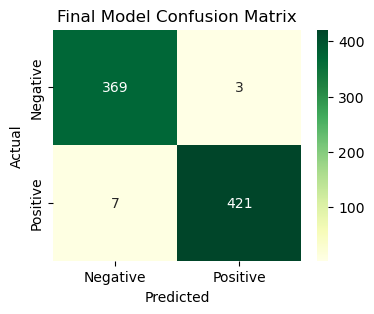

In [172]:
# Visualize the confusion matrix for the final model
cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='YlGn',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Final Model Confusion Matrix')
plt.show()

In [173]:
# Print classification report for the final model
print("\nFinal Model Classification Report:")
print(classification_report(y_test, y_pred_final))


Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       372
           1       0.99      0.98      0.99       428

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



### Explainability

In [174]:
# Initialize the SHAP explainer
explainer = shap.Explainer(lgbm_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



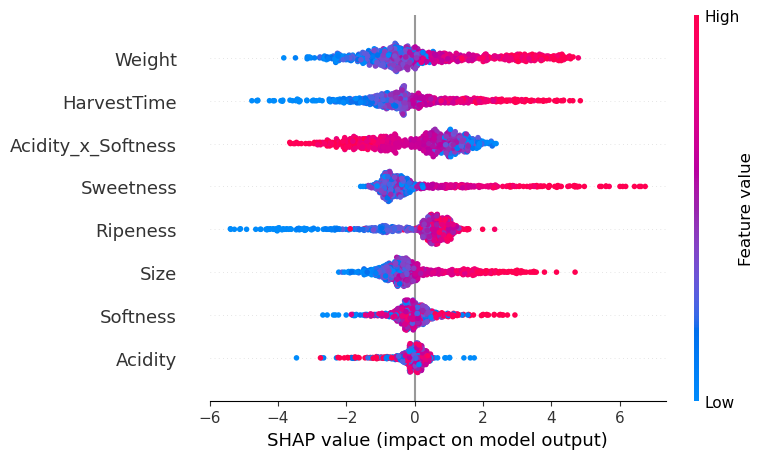

In [175]:
# Summary plot of feature importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
plt.show()


<Figure size 1200x400 with 0 Axes>

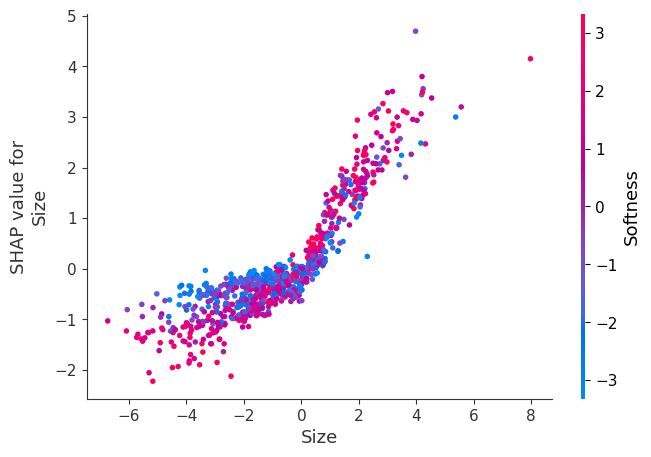

<Figure size 1200x400 with 0 Axes>

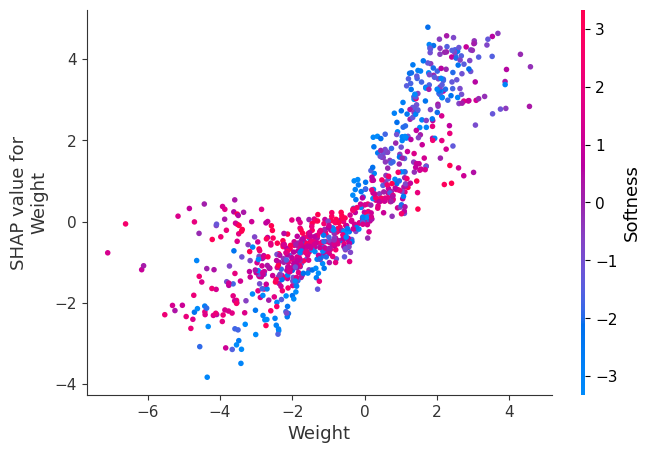

<Figure size 1200x400 with 0 Axes>

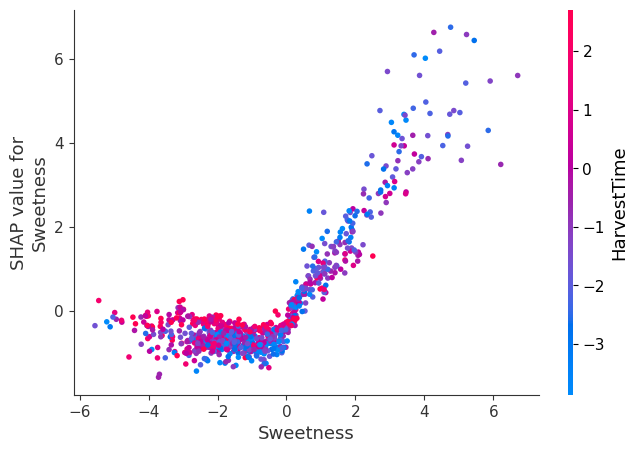

<Figure size 1200x400 with 0 Axes>

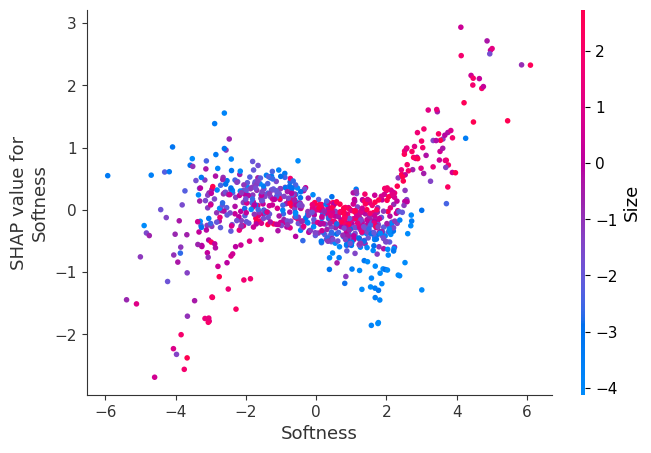

<Figure size 1200x400 with 0 Axes>

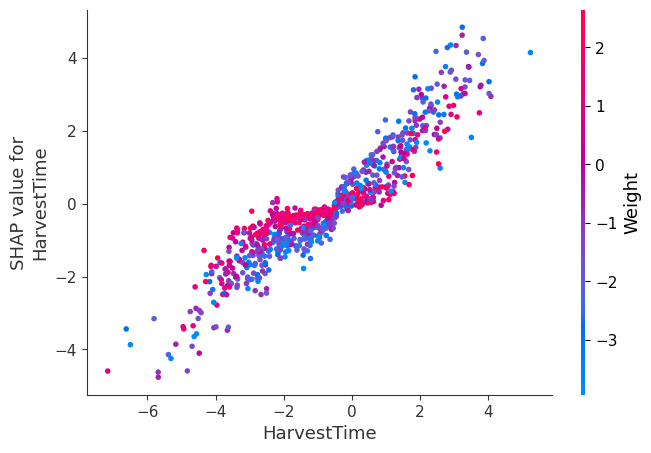

<Figure size 1200x400 with 0 Axes>

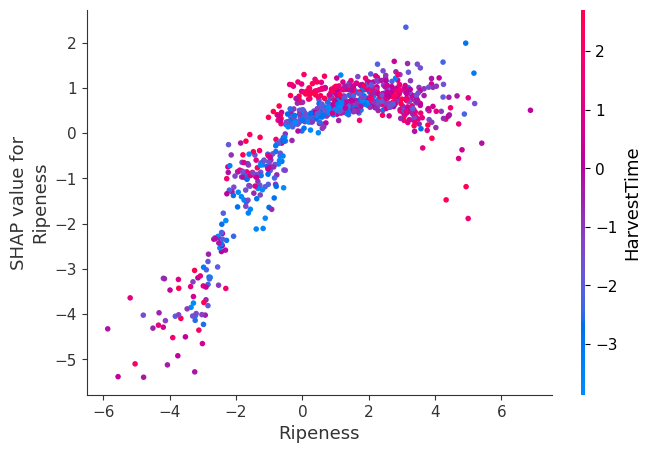

<Figure size 1200x400 with 0 Axes>

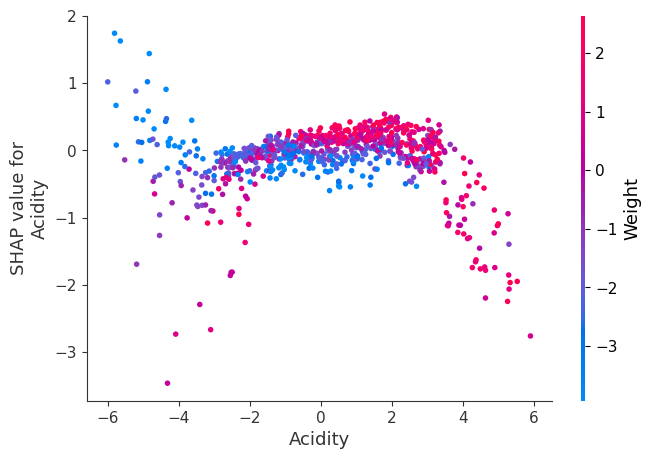

<Figure size 1200x400 with 0 Axes>

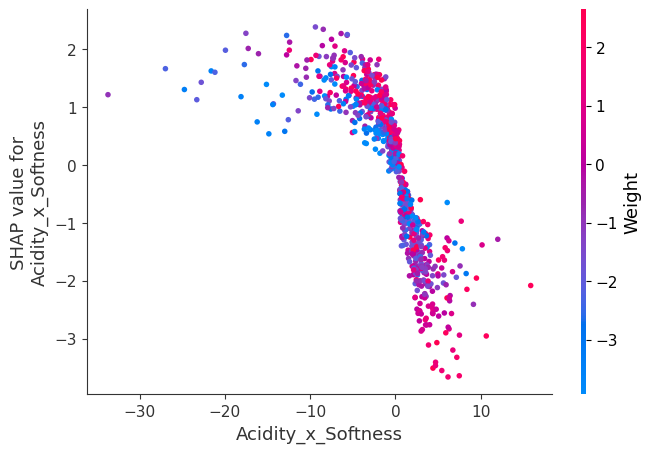

In [176]:
# Iterate through each feature name in X_test.columns
for feature in X_test.columns:
    plt.figure(figsize=(12, 4))
    shap.dependence_plot(feature, shap_values, X_test, feature_names=X_test.columns)
    plt.show()


### Thresholds

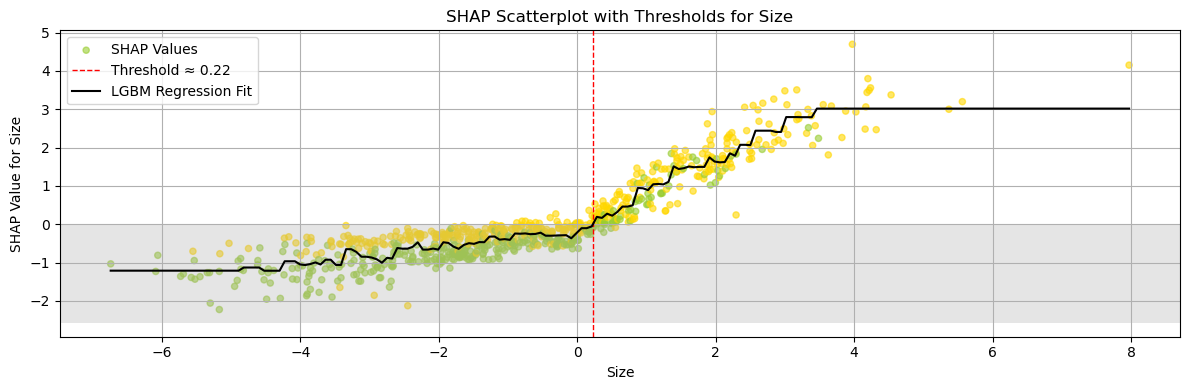

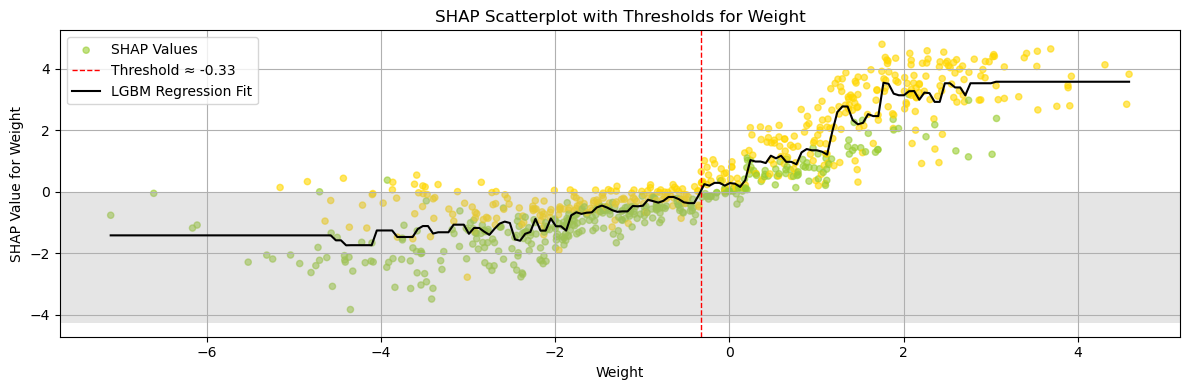

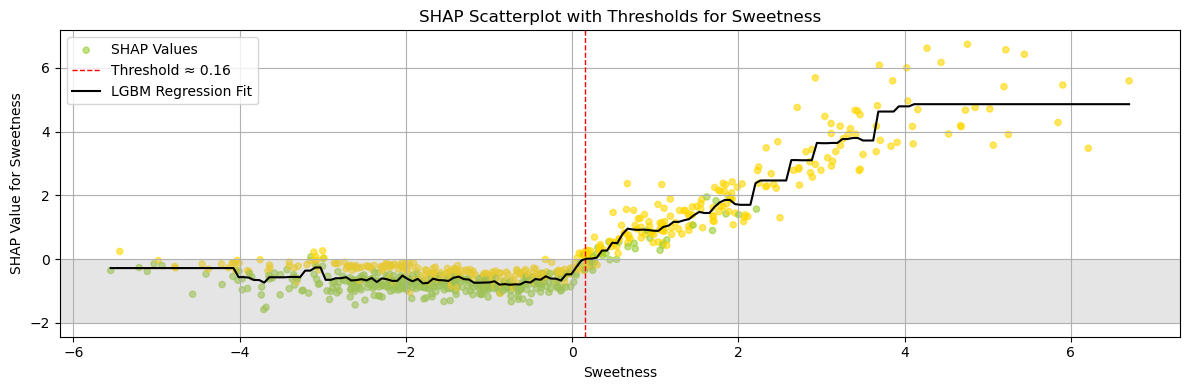

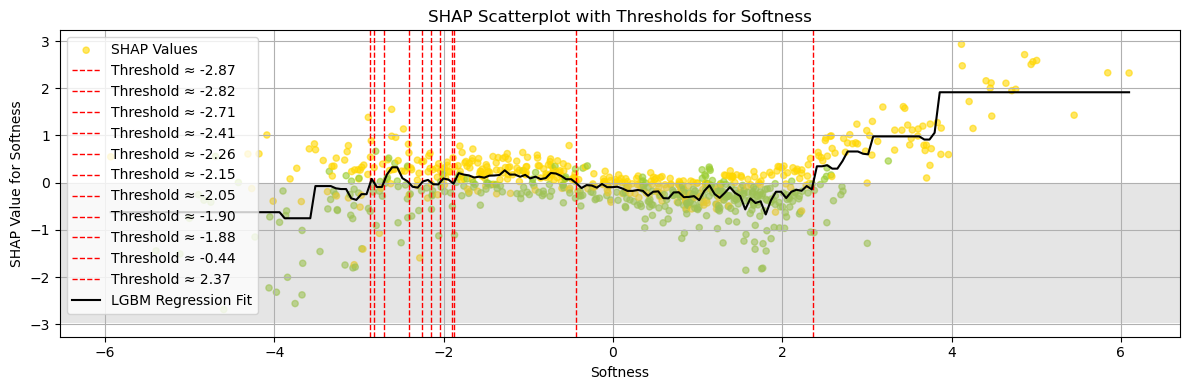

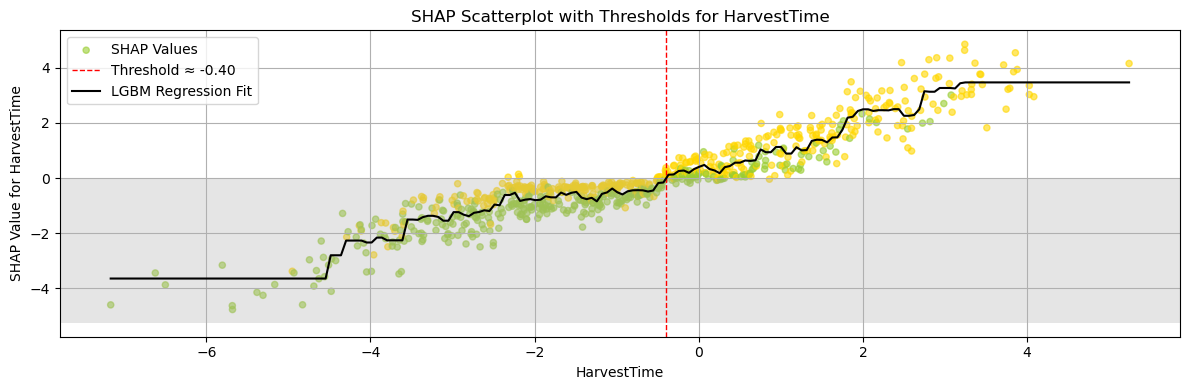

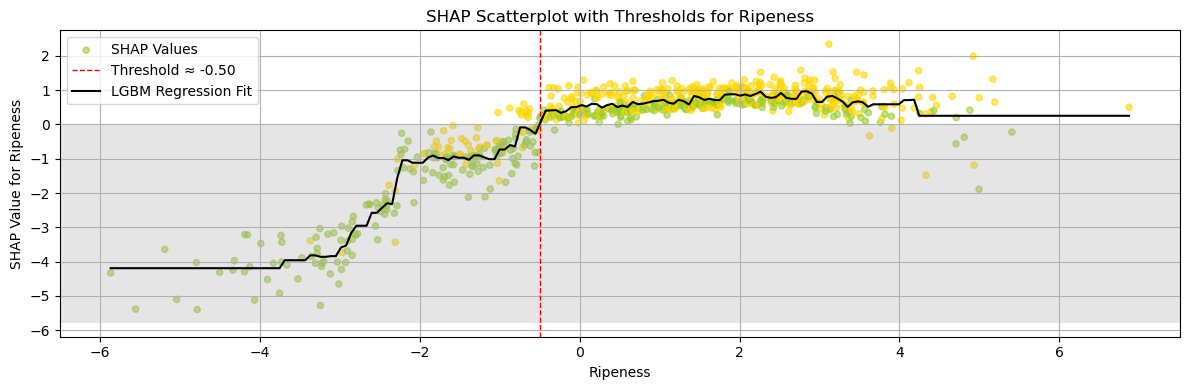

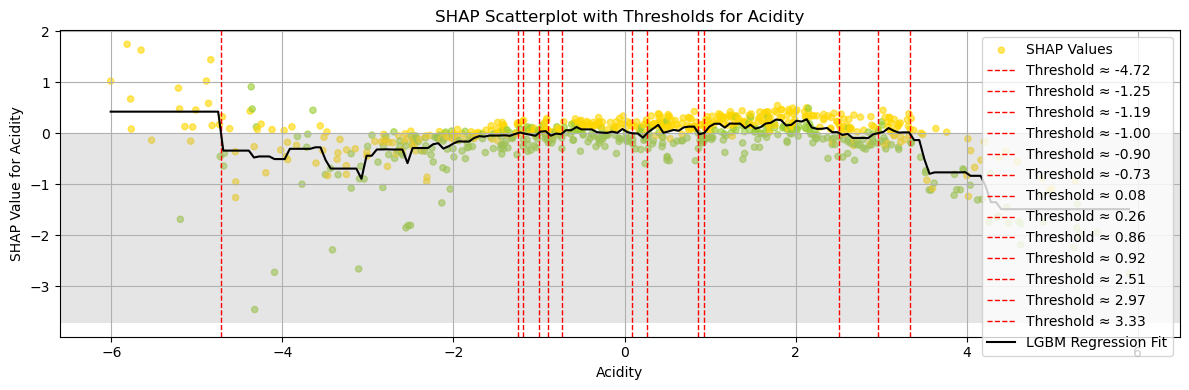

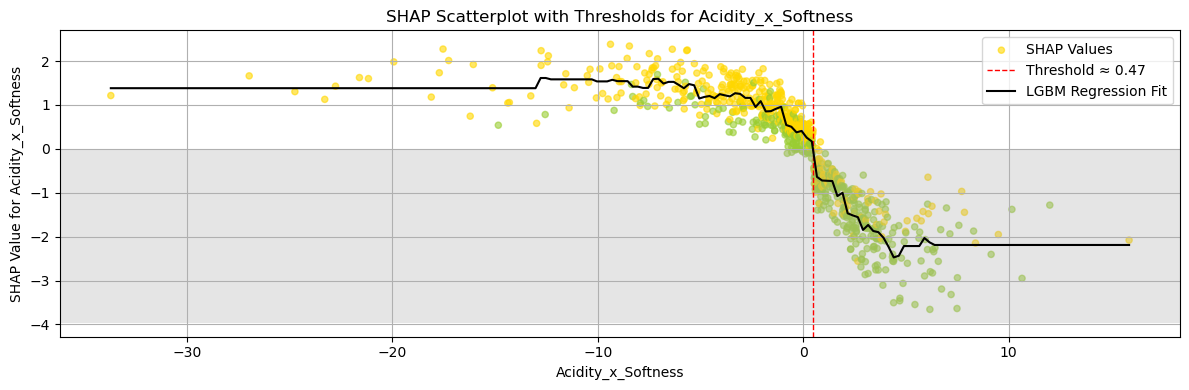

In [177]:

thresholds = {}

# Iterate through each feature
for i, feature_name in enumerate(X_test.columns):

    # SHAP values for the current feature
    feature_values = X_test[feature_name].values
    shap_feature_values = shap_values[:, i]

    # Determine colors based on 'Quality'
    colors = np.where(y_test == 1, good_color, bad_color)

    # Sort data for plotting and fitting
    sorted_indices = np.argsort(feature_values.flatten())
    sorted_feature_values = feature_values[sorted_indices]
    sorted_shap_feature_values = shap_feature_values[sorted_indices]
    sorted_colors = colors[sorted_indices]

    # Convert sorted_feature_values to a DataFrame for the regressor
    X_fit_regressor = pd.DataFrame(sorted_feature_values.reshape(-1, 1), columns=[feature_name])

    # Fit a small LightGBMRegressor
    lgbm_reg = lgb.LGBMRegressor(objective='regression', n_estimators=50, learning_rate=0.1, random_state=42, silent=True)
    lgbm_reg.fit(X_fit_regressor, sorted_shap_feature_values)

    # Predict SHAP value for a range of feature values
    feature_range_values = np.linspace(sorted_feature_values.min(), sorted_feature_values.max(), 200)
    X_predict_regressor = pd.DataFrame(feature_range_values.reshape(-1, 1), columns=[feature_name])
    predicted_shap = lgbm_reg.predict(X_predict_regressor)

    # Find approximate zero-crossing points
    zero_crossings = []
    sign_changes = np.where(np.diff(np.sign(predicted_shap)))[0]
    for idx in sign_changes:
        # Linear interpolation to approximate the zero-crossing value
        x1, y1 = feature_range_values[idx], predicted_shap[idx]
        x2, y2 = feature_range_values[idx + 1], predicted_shap[idx + 1]
        if y1 * y2 < 0:  # Ensure a sign change occurred
            zero_crossing = x1 - y1 * (x2 - x1) / (y2 - y1)
            zero_crossings.append(zero_crossing)

    # Store the results
    thresholds[feature_name] = {
        'Predicted Thresholds': zero_crossings,
        'Mean': X_test[feature_name].mean(),
        'Median': X_test[feature_name].median()
    }

    # Create the DataFrame from the dictionary
    results_df = pd.DataFrame.from_dict(thresholds, orient='index')

    # Plot the SHAP Threshold Scatterplot
    plt.figure(figsize=(12, 4))
    plt.scatter(sorted_feature_values, sorted_shap_feature_values, s=20, c=sorted_colors, alpha=0.6, label='SHAP Values')
    # Add red vertical lines for each zero crossing
    for crossing in zero_crossings:
        plt.axvline(x=crossing, color='red', linestyle='--', linewidth=1, label=f'Threshold ≈ {crossing:.2f}')
    y_min, y_max = plt.ylim()
    plt.axhspan(y_min, 0, facecolor='darkgrey', alpha=0.3)
    plt.plot(feature_range_values, predicted_shap, color='black', linestyle='-', label='LGBM Regression Fit')
    plt.xlabel(feature_name)
    plt.ylabel(f'SHAP Value for {feature_name}')
    plt.title(f'SHAP Scatterplot with Thresholds for {feature_name}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [178]:
# Print the DataFrame with all zero-crossing points
print("DataFrame of Predicted Thresholds:")
results_df['Predicted Thresholds'] = results_df['Predicted Thresholds'].apply(lambda x: [val.round(2) for val in x])
results_df.round(2)

DataFrame of Predicted Thresholds:


,Predicted Thresholds,Mean,Median
Size,[0.22],-0.78,-0.89
Weight,[-0.33],-0.62,-0.74
Sweetness,[0.16],-0.69,-0.97
Softness,"[-2.87, -2.82, -2.71, -2.41, -2.26, -2.15, -2....",0.01,0.33
HarvestTime,[-0.4],-0.79,-0.95
Ripeness,[-0.5],0.73,1.02
Acidity,"[-4.72, -1.25, -1.19, -1.0, -0.9, -0.73, 0.08,...",0.17,0.32
Acidity_x_Softness,[0.47],-0.86,-0.14
